In [1]:
from logging import getLogger 
from eden.util import configure_logging
configure_logging(getLogger('root'),verbosity=1)

In [2]:
%time
'''
first we test the core/interface extractor, since it is most essential
'''
import sys
sys.path.append('..')
%matplotlib inline
# output workaround, sometimes necessary
#import matplotlib
#matplotlib.use('Agg')
from eden.converter.graph.gspan import gspan_to_eden
from graphlearn.graphlearn import GraphLearnSampler
from eden.graph import Vectorizer
import matplotlib.pyplot as plt
import itertools
from graphlearn.utils import myeden
from eden.util import fit_estimator as eden_fit_estimator
from eden.util import selection_iterator as picker
from sklearn.linear_model import SGDClassifier
import random


# a vectorizer
vectorizer = Vectorizer( complexity=2 )

# select 1st element in an iterator
def unpack(graphs):
    for graphlist in graphs:
        yield graphlist[0]


def make_estimator(pos,neg):
    pos = vectorizer.transform( pos )
    neg = vectorizer.transform( neg )
    esti = eden_fit_estimator(SGDClassifier(), positive_data_matrix=pos,
                                        negative_data_matrix=neg)
    return esti



# positive set contains 2401 elements, of which we use 30% to test of we cen improve them ,
# the rest is used for the oracle
lenpo=int(2401*.3)


# we select those 30% randomly:
splitset= range(2014)
random.shuffle(splitset)
sample=splitset[:lenpo]
oracle=splitset[lenpo:]


# we create an oracle
estimator=make_estimator(picker(gspan_to_eden('bursi.pos.gspan'),oracle),gspan_to_eden('bursi.neg.gspan'))
print 'estimator ok'


CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.01 µs
estimator ok


In [3]:
%%time
import numpy as np
from time import time

# ok we create an iterator over the graphs we want to work with... 
graphs_pos= picker( gspan_to_eden('bursi.pos.gspan') , sample)

# save results here:
original_score=[]
sample_score=[]

# we want to use an increasing part of the test set.. 
percentages=[ 0.01, 0.05, 0.12, 0.25, 0.5 ,1 ]
percentages=[ 0.1, 0.2, 0.4, 0.6, 0.8 ]

sampler = GraphLearnSampler(radius_list=[0, 1, 2],thickness_list=[2, 4], complexity=2)

for percentage in percentages:  
    start=time()
    # we work with n_graphs many graphs
    n_graphs = int(lenpo*percentage)

    # make copy of graphiterator
    # select count random elements
    # triplicate  the count long iterator
    graphs_pos, graphs_pos_ = itertools.tee(graphs_pos)
    ids=range(n_graphs)
    random.shuffle(ids)
    graphs_pos_ = picker(graphs_pos_, ids )
    graphs_pos_,graphs_pos__,graphs_pos___ = itertools.tee(graphs_pos_,3)

    # do sampling
    sampler.fit(graphs_pos__,n_jobs=-1)

    n_steps=2
    sampling_interval=1
    samples = sampler.sample( graphs_pos_,
                        same_radius=False,
                        same_core_size=True,
                        sampling_interval=sampling_interval,
                        select_cip_max_tries=200,
                        batch_size=int(n_graphs/4)+1,
                        n_steps=n_steps,
                        n_jobs=-1,
                        annealing_factor=1.5)
    
    #calculate the score of the sample
    avg_sample = np.mean( [estimator.decision_function(e) for e in vectorizer.transform(unpack(samples)) ] )
    #calculate score of the originals
    avg_original = np.mean( [estimator.decision_function(e) for e in vectorizer.transform(graphs_pos___)] )
    sample_score.append(avg_sample)
    original_score.append(avg_original)
    
    duration=time()-start
    print '%.2f #:%d sec:%.1f sample_score:%.3f original_score:%.3f'%(percentage,n_graphs,duration, avg_sample, avg_original)

0.10 #:72 sec:24.5 sample_score:-0.557 original_score:0.523
0.20 #:144 sec:39.9 sample_score:-0.568 original_score:0.641
0.40 #:288 sec:71.9 sample_score:-0.569 original_score:0.645


/Library/Python/2.7/site-packages/sklearn/calibration.py:398: RuntimeWarning: overflow encountered in exp
  E = np.exp(AB[0] * F + AB[1])
/Library/Python/2.7/site-packages/sklearn/calibration.py:408: RuntimeWarning: overflow encountered in exp
  E = np.exp(AB[0] * F + AB[1])
/Library/Python/2.7/site-packages/sklearn/calibration.py:410: RuntimeWarning: invalid value encountered in multiply
  TEP_minus_T1P = P * (T * E - T1)


0.60 #:432 sec:104.6 sample_score:-0.573 original_score:0.688
0.80 #:576 sec:141.8 sample_score:-0.570 original_score:0.689
CPU times: user 3min 51s, sys: 20.7 s, total: 4min 12s
Wall time: 6min 22s


[0.52312393341882324, 0.64051515875264853, 0.64471752959677797, 0.6881695012055894, 0.68899851656513522]
[-0.55732327433335227, -0.56808320761660713, -0.56912621941221941, -0.57257699214784219, -0.56976473152207352]


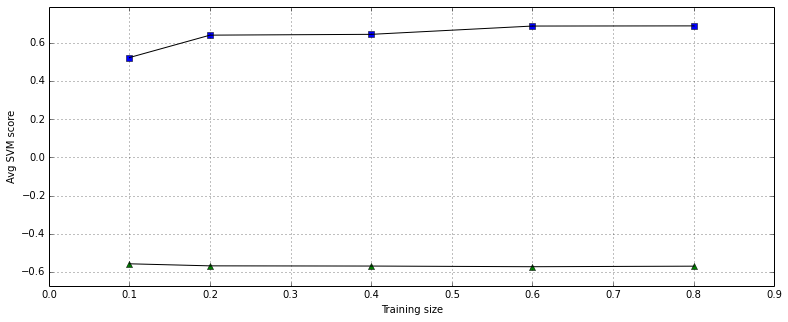

In [4]:
# originals are blue
# improved ones are green
print original_score
print sample_score
plt.figure(figsize=(13, 5))
margin=0.1
plt.xlabel('Training size')
plt.ylabel('Avg SVM score')
plt.xlim(0,max(percentages)+margin) 
plt.ylim(min(min(original_score),min(sample_score))-margin,max(max(original_score),max(sample_score))+margin) 
plt.plot(percentages, original_score ,'bs', percentages,original_score ,'k')
plt.plot(percentages, sample_score ,'g^', percentages, sample_score ,'k')
plt.grid()
plt.savefig('sample_score.pdf')